# Определение возраста покупателей

__Описание проекта__


Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.


__Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.__
    
    
Инструкция по выполнению проекта:
- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [1]:
# импортируем необходимые библиотеки

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# загрузим наши данные

try:
    labels = pd.read_csv('/Users/alex/Downloads/labels.csv')
except:
    labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
# взглянем, что из себя представляет наш файл 

display(labels.shape)
display(labels.info())

(7591, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

In [4]:
# выведем несколько строк 

labels.sample(10)

,file_name,real_age
985,000985.jpg,43
6165,006168.jpg,52
4083,004083.jpg,19
7203,007221.jpg,43
1461,001461.jpg,30
7469,007491.jpg,25
3163,003163.jpg,28
4259,004259.jpg,60
140,000140.jpg,26
1587,001587.jpg,25


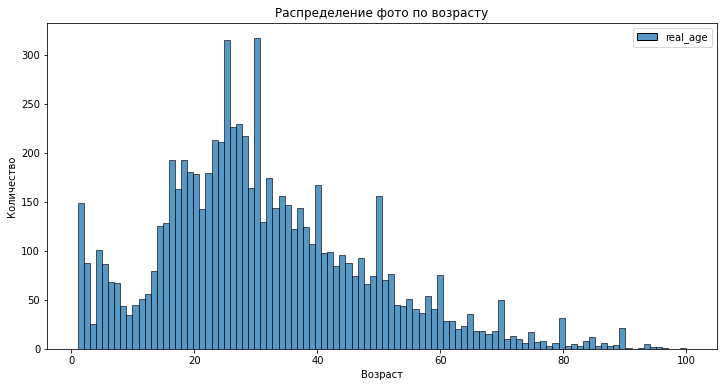

In [5]:
# взглянем на распределение возраста('real_age') в наших данных

plt.figure(figsize=(12, 6))
sns.histplot(labels, bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение фото по возрасту')
plt.show()

In [6]:
# применим функцию next(), чтобы получить пару - фичи(фото) & таргет(возраст)

features, target = next(train_gen_flow)

print(features.shape)

(32, 224, 224, 3)


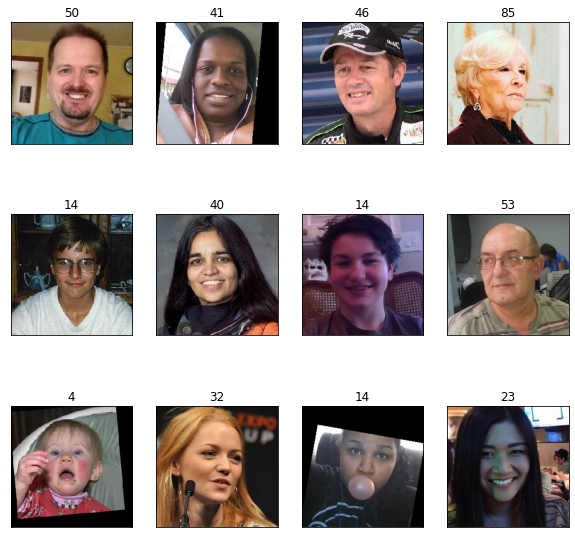

In [7]:
# взглянем на имеющиеся фото

fig = plt.figure(figsize=(10, 10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.title(target[i]) 
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])

__Промежуточный вывод__

- у нас имеется файл с 7591 изображением ледей и данными об их возрасте
- часть фотографий представленны, как черно-белые(вероятно исторически старые фото) и цветные более современные, так же имеются изображения со смещенным центром(это либо специольно созданные путтем аугментации, чтобы увеличить нашу выборку, либо действительно исторически неправильного формата фото)
- распределение по возрасту не нормальное, скошено вправо. Больше всего представлено фотографий людей в возрасте приблезительно от 18 до 40 лет.

Что касается дальнейшего обучения и как результаты исследования повлияет на это:
1. фото возрастной группы условно до 5 лет,на мой взгляд -  это шум и 'выбросы' т/к у нас стояла задача определения возрастной группы для дальнейшего понимания, что предлать ей, врядли дети до 5 лет ходят самостоятельно в магазин, и уж тем более проверять добросовестность кассиров при продажи алкоголя
2. в целом выборка фотографий не очень соответствует требованиям задачи, было бы лучше использовать актуальные фотографии из магазина / данные покупателей, если бы была такая возможность.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python


import numpy as np
import pandas as pd
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50



def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1./255, validation_split=0.25, horizontal_flip=True)
    train_data = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_data


def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_data = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_data


def create_model(input_shape):
    model = Sequential()
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model


```

```

Epoch 1/10
2024-01-22 09:16:07.645672: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-01-22 09:16:08.816221: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 66s - loss: 233.1399 - mae: 10.9653 - val_loss: 1008.8081 - val_mae: 27.0711
Epoch 2/10
178/178 - 38s - loss: 76.6874 - mae: 6.5925 - val_loss: 645.3141 - val_mae: 20.2750
Epoch 3/10
178/178 - 38s - loss: 49.7089 - mae: 5.3897 - val_loss: 255.6238 - val_mae: 11.8564
Epoch 4/10
178/178 - 38s - loss: 35.0952 - mae: 4.5230 - val_loss: 124.8864 - val_mae: 8.3511
Epoch 5/10
178/178 - 38s - loss: 26.4235 - mae: 3.8896 - val_loss: 111.9528 - val_mae: 8.3352
Epoch 6/10
178/178 - 38s - loss: 22.0471 - mae: 3.5592 - val_loss: 71.0426 - val_mae: 6.3315
Epoch 7/10
178/178 - 38s - loss: 18.1161 - mae: 3.2464 - val_loss: 70.9021 - val_mae: 6.3608
Epoch 8/10
178/178 - 38s - loss: 15.6506 - mae: 3.0099 - val_loss: 74.5215 - val_mae: 6.3791
Epoch 9/10
178/178 - 38s - loss: 11.8676 - mae: 2.6444 - val_loss: 80.9376 - val_mae: 7.0465
Epoch 10/10
178/178 - 38s - loss: 11.3060 - mae: 2.5708 - val_loss: 78.5864 - val_mae: 6.5232
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 78.5864 - mae: 6.5232
Test MAE: 6.5232

```

__ВЫВОД__

Создали нейронную сеть с архитектурой ResNet50. Подобрали подходящий шаг обучения и кол-во эпох(при бОльшем количестве эпох и более высоком шаге, замечал переобучение, буквально подбирались к нужному значению MAE около 6-7, как вдруг на следующих шагах(эпохах) значение на трейн и тест начинали __расходиться врозь__, а имеено - MAE на тесте значительно увеличивалось). Оптимизатор выбрали Adam, где learning_rate = 0.0004. По итогам обучения, нам удалось достичь поставленной цели, а именно значение средней абсолютной ошибки < 8 на тестовой выборке: __train_mae: 2.57 / val_mae: 6.52__

В общем и целом, на мой взляд модель справилась нормально...

Комментируя задачу:

__"Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы"__ если учитывать +- возраст потенциального покупателя, чтобы отнести его к той или иной возрастной группе, условно подростки/молодые люди/люди среднего возраста и т.д... и основываясь на этом предлагать им товары то - ок.

А что касается __"Контролировать добросовестность кассиров при продаже алкоголя."__ - тут на мой взгляд нужна более сложная и умная и хитрая модель))) условно обучена специально на бородатых подростках, но при этом чтобы она распознавала само лицо, какие то условные морщин, глаза, взгляд и тд, т.к молодеж бывает выглядит весьма старше своего биологического возраста, а глаз кассира не всегда может определить это) 